In [2]:
# Cell 1: Install, Import, and Load Data

# Install necessary libraries (usually pre-installed in Colab, but good for completeness)
!pip install pandas numpy scikit-learn matplotlib seaborn

import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from sklearn.ensemble import HistGradientBoostingClassifier
from sklearn.metrics import roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset (Ensure 'loan_data.csv' is uploaded to your Colab session)
try:
    df = pd.read_csv('loan_data.csv')
    print("✅ Data loaded successfully.")
except FileNotFoundError:
    print("❌ Error: 'loan_data.csv' not found. Please upload the file to your Colab session.")
    # Stop execution if data is missing
    raise

# Initial Data Check
print(f"\nOriginal Data Shape: {df.shape}")
print("\nFirst 5 rows of data:")
print(df.head())
print("\nColumn data types and missing values:")
print(df.info())

✅ Data loaded successfully.

Original Data Shape: (171409, 13)

First 5 rows of data:
   id  annual_income  debt_to_income_ratio  credit_score  loan_amount  \
0   0       29367.99                 0.084           736      2528.42   
1   1       22108.02                 0.166           636      4593.10   
2   2       49566.20                 0.097           694     17005.15   
3   3       46858.25                 0.065           533      4682.48   
4   4       25496.70                 0.053           665     12184.43   

   interest_rate  gender marital_status education_level employment_status  \
0          13.67  Female         Single     High School     Self-employed   
1          12.92    Male        Married        Master's          Employed   
2           9.76    Male         Single     High School          Employed   
3          16.10  Female         Single     High School          Employed   
4          10.21    Male        Married     High School          Employed   

         loa

In [4]:
# Cell 2: Define Target and Split Data

TARGET = 'loan_paid_back'
FEATURES_TO_EXCLUDE = ['id', 'grade'] # Exclude unique ID and high-level 'grade' (using 'subgrade')
FEATURES = [col for col in df.columns if col not in [TARGET] + FEATURES_TO_EXCLUDE]

# Identify feature types
numerical_features = ['annual_income', 'debt_to_income_ratio', 'credit_score', 'loan_amount', 'interest_rate']
nominal_categorical_features = ['gender', 'marital_status', 'loan_purpose', 'employment_status']
ordinal_categorical_features = ['education_level', 'subgrade']

# Drop rows where the target variable is NaN
df.dropna(subset=[TARGET], inplace=True)
print(f"\nData shape after dropping NaN target values: {df.shape}")

# Check Target Imbalance (optional)
print("\nTarget Variable Distribution:")
print(df[TARGET].value_counts(normalize=True))

# Separate features (X) and target (y)
X = df[FEATURES]
y = df[TARGET]

# Split the data (80% Train, 20% Test) using stratification to maintain class ratio
X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42,
    stratify=y
)

print(f"\nTraining set shape: {X_train.shape}")
print(f"Testing set shape: {X_test.shape}")


Data shape after dropping NaN target values: (171408, 13)

Target Variable Distribution:
loan_paid_back
1.0    0.797693
0.0    0.202307
Name: proportion, dtype: float64

Training set shape: (137126, 11)
Testing set shape: (34282, 11)


In [5]:
# Cell 3: Build Preprocessing Pipeline

# --- Define Ordinal Category Orders ---
# 1. Education Level: Ensure these levels match your dataset's unique values
education_order = [
    '< high school',
    'high school',
    'some college',
    "associate's degree",
    "bachelor's degree",
    "master's degree",
    'doctorate'
]

# 2. Subgrade: Get unique values from TRAINING data and sort them (A1, A2, ..., B1, B2, ...)
# This ensures sorting based on risk hierarchy.
# Fix: Changed 'subgrade' to 'grade_subgrade' to match the actual column name in the DataFrame
subgrade_order = sorted(X_train['grade_subgrade'].dropna().unique().tolist())

# --- Preprocessing Steps using Pipelines ---

# 1. Numerical Pipeline: Impute with median, then Scale (StandardScaler)
numerical_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

# 2. Nominal Categorical Pipeline: Impute with mode, then One-Hot Encode
nominal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('onehot', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
])

# 3. Ordinal Categorical Pipeline: Impute with mode, then Ordinal Encode
ordinal_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('ordinal', OrdinalEncoder(
        categories=[education_order, subgrade_order],
        handle_unknown='use_encoded_value',
        unknown_value=-1)
    )
])

# Combine all transformers using ColumnTransformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_pipeline, numerical_features),
        ('nominal_cat', nominal_pipeline, nominal_categorical_features),
        # Fix: Changed 'subgrade' to 'grade_subgrade' in the ordinal_categorical_features list
        ('ordinal_cat', ordinal_pipeline, ['education_level', 'grade_subgrade'])
    ],
    remainder='drop' # Drop any columns not specified
)

print("✅ Preprocessing pipeline created.")

✅ Preprocessing pipeline created.



Starting GridSearchCV for model tuning (This may take a few minutes)...
Fitting 3 folds for each of 8 candidates, totalling 24 fits

✅ Best Model Parameters: {'classifier__learning_rate': 0.05, 'classifier__max_leaf_nodes': 50, 'classifier__min_samples_leaf': 40}

🚀 Final Model Test AUC: 0.9152


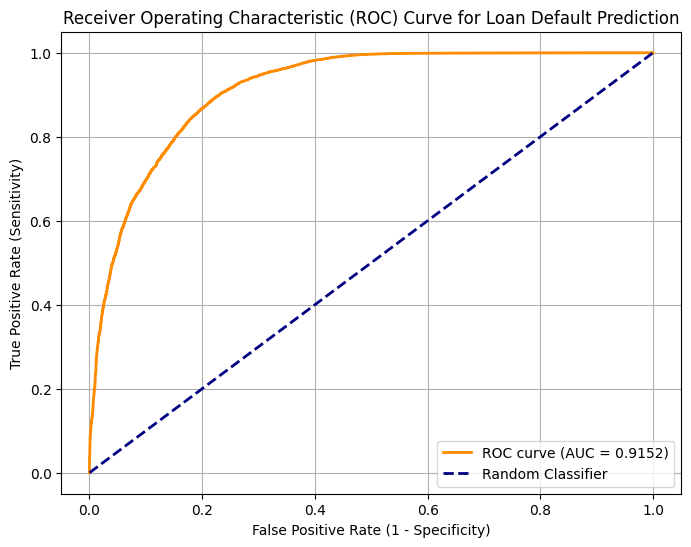

In [6]:
# Cell 4: Model Training and Evaluation (AUC Maximization)

# Final Model Pipeline: Preprocessor -> Classifier
model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', HistGradientBoostingClassifier(random_state=42))
])

# Hyperparameter Tuning Grid (focused search for efficiency)
param_grid = {
    'classifier__learning_rate': [0.05, 0.1],
    'classifier__max_leaf_nodes': [31, 50],
    'classifier__min_samples_leaf': [20, 40]
}

# GridSearchCV: Optimizes for the maximum ROC AUC score
print("\nStarting GridSearchCV for model tuning (This may take a few minutes)...")
grid_search = GridSearchCV(
    model_pipeline,
    param_grid,
    scoring='roc_auc',
    cv=3, # 3-fold cross-validation
    verbose=2,
    n_jobs=-1
)

# Fit the model and find the best parameters
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_
print(f"\n✅ Best Model Parameters: {grid_search.best_params_}")

# --- Evaluation on Test Set ---
# Predict probabilities for the positive class (loan_paid_back=1)
y_pred_proba = best_model.predict_proba(X_test)[:, 1]

# Calculate Final Test AUC
final_auc = roc_auc_score(y_test, y_pred_proba)
print(f"\n🚀 Final Model Test AUC: {final_auc:.4f}")

# --- Generate ROC Curve Plot ---
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc_val = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc_val:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='Random Classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.title('Receiver Operating Characteristic (ROC) Curve for Loan Default Prediction')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

In [7]:
# Cell 5: Subgroup Analysis

def calculate_subgroup_auc(X_group, y_group, model):
    """Calculates AUC for a specific subgroup."""
    # Must have both classes (0 and 1) to calculate AUC
    if len(y_group.unique()) < 2:
        return np.nan

    # Predict probabilities and calculate AUC
    group_proba = model.predict_proba(X_group)[:, 1]
    return roc_auc_score(y_group, group_proba)

# ----------------------------------------------------
# 4.1. Analysis by education_level
# ----------------------------------------------------
education_results = {}
education_levels = X_test['education_level'].unique()

for level in education_levels:
    mask = X_test['education_level'] == level
    X_group = X_test[mask]
    y_group = y_test[mask]

    auc_result = calculate_subgroup_auc(X_group, y_group, best_model)
    education_results[level] = auc_result

df_education = pd.DataFrame.from_dict(education_results, orient='index', columns=['Subgroup AUC']).sort_values(by='Subgroup AUC', ascending=False).dropna()

print("\n### Subgroup AUC by Education Level ###")
print(df_education)


# ----------------------------------------------------
# 4.2. Analysis by loan_purpose (Top 3 and Bottom 3)
# ----------------------------------------------------

# Find the frequency of each loan purpose in the test set
purpose_counts = X_test['loan_purpose'].value_counts()

# Ensure we handle cases where there might be fewer than 3 unique purposes
n_top = min(3, len(purpose_counts))
n_bottom = min(3, len(purpose_counts) - n_top)

top_3_purposes = purpose_counts.nlargest(n_top).index.tolist()
bottom_3_purposes = purpose_counts.nsmallest(n_bottom).index.tolist()

relevant_purposes = list(set(top_3_purposes + bottom_3_purposes)) # Use set to avoid duplicates

purpose_results = {}

for purpose in relevant_purposes:
    mask = X_test['loan_purpose'] == purpose
    X_group = X_test[mask]
    y_group = y_test[mask]

    auc_result = calculate_subgroup_auc(X_group, y_group, best_model)
    purpose_results[purpose] = auc_result

df_purpose = pd.DataFrame.from_dict(purpose_results, orient='index', columns=['Subgroup AUC']).dropna()

print("\n### Subgroup AUC by Loan Purpose (Top 3 & Bottom 3) ###")
print(df_purpose)


### Subgroup AUC by Education Level ###
             Subgroup AUC
Other            0.929646
Bachelor's       0.917497
PhD              0.914645
Master's         0.912086
High School      0.910814

### Subgroup AUC by Loan Purpose (Top 3 & Bottom 3) ###
                    Subgroup AUC
Vacation                0.928403
Other                   0.908231
Business                0.912282
Debt consolidation      0.917219
Car                     0.904739
Medical                 0.917136
